In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [13]:
df=pd.read_csv('Frozen_Dessert_Production.csv',index_col='DATE',parse_dates=['DATE'])  ###parse_dates=True

In [10]:
df

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636
...,...
2019-05-01,114.5613
2019-06-01,124.9605
2019-07-01,110.2632


In [12]:
print(df.index.dtype)

datetime64[ns]


In [14]:
df.columns=['Production']

<Axes: xlabel='DATE'>

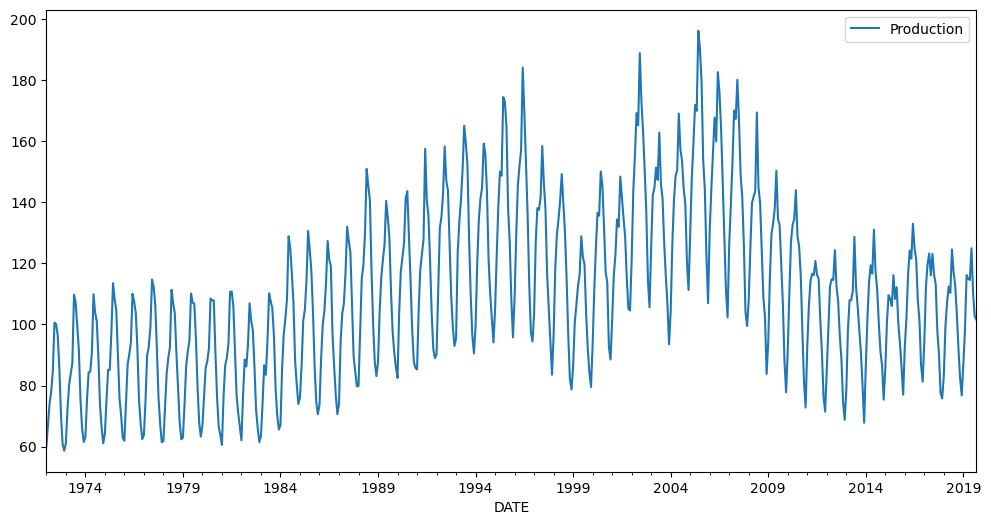

In [15]:
df.plot(figsize=(12,6))

In [16]:
len(df)

573

In [18]:
test_size=24
test_index=len(df)-test_size

In [19]:
train=df[:test_index]
test=df[test_index:]

In [23]:
len(train), len(test)

(549, 24)

In [24]:
from sklearn.preprocessing import MinMaxScaler

In [25]:
scaler=MinMaxScaler()

In [26]:
train_scale=scaler.fit_transform(train)

In [27]:
test_scale=scaler.transform(test)

In [28]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [30]:
length=18   ###length is 18 month to capture 1 year seasonality
n_feature=1
generator=TimeseriesGenerator(train_scale,train_scale,length=length,batch_size=1)
validation_generator=TimeseriesGenerator(test_scale,test_scale,length=length,batch_size=1)

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [45]:
model=Sequential()

In [46]:
model.add(LSTM(150,input_shape=(length,n_feature)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [47]:
early_stop=EarlyStopping(monitor='val_loss',patience=2)

In [48]:
model.fit(generator,epochs=20,validation_data=validation_generator,callbacks=[early_stop])

Epoch 1/20
531/531 [==============================] - 15s 20ms/step - loss: 0.0141 - val_loss: 0.0020
Epoch 2/20
531/531 [==============================] - 9s 17ms/step - loss: 0.0048 - val_loss: 0.0018
Epoch 3/20
531/531 [==============================] - 9s 18ms/step - loss: 0.0041 - val_loss: 0.0020
Epoch 4/20
531/531 [==============================] - 9s 17ms/step - loss: 0.0037 - val_loss: 0.0025


In [49]:
df_loss=pd.DataFrame(model.history.history)

In [50]:
df_loss

,loss,val_loss
0,0.014111,0.001984
1,0.004759,0.001803
2,0.004082,0.001966
3,0.003656,0.002498


<Axes: >

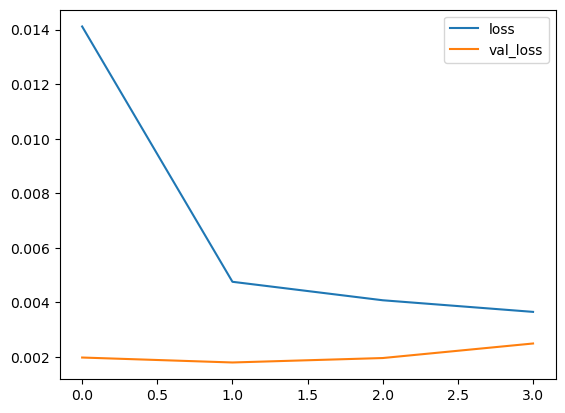

In [51]:
df_loss.plot()

#### Predict test data

In [56]:
test_prediction=[]

first_eval_batch=train_scale[-length:]
current_batch=first_eval_batch.reshape(1,length,n_feature)
for i in range(len(test)):
    prediction=model.predict(current_batch)[0]
    test_prediction.append(prediction)
    current_batch=np.append(current_batch[:,1:,:],[[prediction]],axis=1)

1/1 [==============================] - 0s 57ms/step


In [57]:
true_prediction=scaler.inverse_transform(test_prediction)

In [58]:
test['prediction']=true_prediction

C:\Users\mrsna\AppData\Local\Temp\ipykernel_29680\1086271440.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction']=true_prediction


<Axes: xlabel='DATE'>

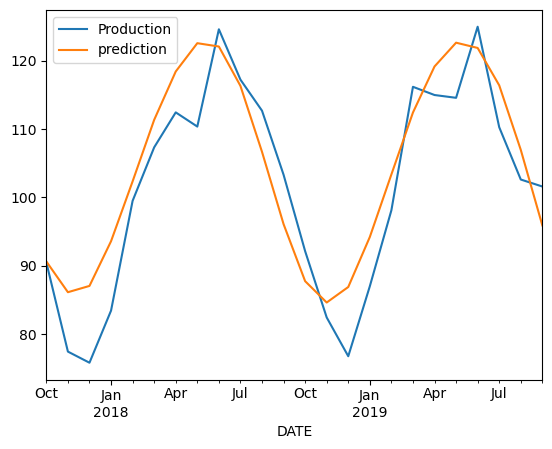

In [59]:
test.plot()

In [53]:
from sklearn.metrics import mean_squared_error

In [60]:
mean_squared_error(test['Production'],test['prediction'])

42.09171892907579

In [61]:
np.sqrt(mean_squared_error(test['Production'],test['prediction']))

6.487813108365236